# ResNet
Resnet网络作者则想到了常规计算机视觉领域常用的residual representation的概念，并进一步将它应用在了CNN模型的构建当中，于是就有了基本的residual learning的block。它通过使用多个有参层来学习输入输出之间的残差表示，而非像一般CNN网络（如Alexnet/VGG等）那样使用有参层来直接尝试学习输入、输出之间的映射。实验表明使用一般意义上的有参层来直接学习残差比直接学习输入、输出间映射要容易得多（收敛速度更快），也有效得多（可通过使用更多的层来达到更高的分类精度）。

## 导入库

In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## 超参

In [2]:
EPOCHS = 10
BATCH_SIZE = 64
LR = 0.1
VERBOSE = 1
VALIDATION_SPLIT = 0.2

## 导入数据集

In [3]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.fashion_mnist.load_data()

In [4]:
train_images = train_images.reshape((60000, 28, 28, 1)).astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1)).astype('float32') / 255

## 定义模型

In [5]:
class Residual(tf.keras.Model):
    def __init__(self, num_channels, use_1x1conv=False, strides=1, **kwargs):
        super(Residual, self).__init__(**kwargs)
        self.conv1 = keras.layers.Conv2D(num_channels, padding='same', kernel_size=3, strides=strides)
        self.conv2 = keras.layers.Conv2D(num_channels, kernel_size=3, padding='same')
        if use_1x1conv:
            self.conv3 = keras.layers.Conv2D(num_channels, kernel_size=1, strides=strides)
        else:
            self.conv3 = None
        self.bn1 = keras.layers.BatchNormalization()
        self.bn2 = keras.layers.BatchNormalization()

    def call(self, X):
        Y = keras.activations.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        return keras.activations.relu(Y + X)

In [6]:
class ResnetBlock(keras.layers.Layer):
    def __init__(self,num_channels, num_residuals, first_block=False,**kwargs):
        super(ResnetBlock, self).__init__(**kwargs)
        self.listLayers=[]
        for i in range(num_residuals):
            if i == 0 and not first_block:
                self.listLayers.append(Residual(num_channels, use_1x1conv=True, strides=2))
            else:
                self.listLayers.append(Residual(num_channels))      
    
    def call(self, X):
        for layer in self.listLayers.layers:
            X = layer(X)
        return X

In [7]:
class ResNet(tf.keras.Model):
    def __init__(self, num_blocks, **kwargs):
        super(ResNet, self).__init__(**kwargs)
        self.conv = keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')
        self.bn = keras.layers.BatchNormalization()
        self.relu = keras.layers.Activation('relu')
        self.mp = keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')
        
        self.resnet_block1 = ResnetBlock(64, num_blocks[0], first_block=True)
        self.resnet_block2 = ResnetBlock(128, num_blocks[1])
        self.resnet_block3 = ResnetBlock(256, num_blocks[2])
        self.resnet_block4 = ResnetBlock(512, num_blocks[3])
        
        self.gap = keras.layers.GlobalAvgPool2D()
        self.fc = keras.layers.Dense(units=10, activation=keras.activations.softmax)

    def call(self, x):
        x=self.conv(x)
        x=self.bn(x)
        x=self.relu(x)
        x=self.mp(x)
        
        x=self.resnet_block1(x)
        x=self.resnet_block2(x)
        x=self.resnet_block3(x)
        x=self.resnet_block4(x)
        
        x=self.gap(x)
        x=self.fc(x)
        return x
    
model = ResNet([2, 2, 2, 2])

## 设置优化器和损失函数

In [8]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

## 开始训练

In [9]:
history = model.fit(train_images, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=VALIDATION_SPLIT)

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 27s 571us/sample - loss: 0.4800 - accuracy: 0.8301 - val_loss: 0.3926 - val_accuracy: 0.8611
Epoch 2/10
48000/48000 [==============================] - 25s 514us/sample - loss: 0.3289 - accuracy: 0.8801 - val_loss: 0.4156 - val_accuracy: 0.8553
Epoch 3/10
48000/48000 [==============================] - 25s 512us/sample - loss: 0.2867 - accuracy: 0.8954 - val_loss: 0.2983 - val_accuracy: 0.8922
Epoch 4/10
48000/48000 [==============================] - 25s 512us/sample - loss: 0.2608 - accuracy: 0.9033 - val_loss: 0.3209 - val_accuracy: 0.8839
Epoch 5/10
48000/48000 [==============================] - 25s 511us/sample - loss: 0.2444 - accuracy: 0.9103 - val_loss: 0.2674 - val_accuracy: 0.9008
Epoch 6/10
48000/48000 [==============================] - 25s 511us/sample - loss: 0.2256 - accuracy: 0.9166 - val_loss: 0.2840 - val_accuracy: 0.9023
Epoch 7/10
48000/48000 [====================

## 绘制梯度下降图

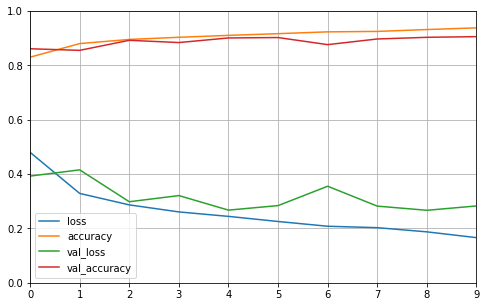

In [13]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()
    
plot_learning_curves(history)

## 测试训练好的模型

In [11]:
model.evaluate(test_images, test_labels)

10000/10000 [==============================] - 2s 237us/sample - loss: 0.2815 - accuracy: 0.9055


[0.2815229339957237, 0.90550005]

## 保存模型 

In [14]:
model.save_weights('./save/save_weights/model_weights.h5')